## Word Recognition

In [28]:
# Select one model from ResNet18, ResNet34, ResNet152, InceptionV3, AlexNet
model_choice = "InceptionV3"

In [2]:
import os

# Get the working directory where the dataset is located
input_dir = '../input'

# Check the working directory
# You should see the datasets
os.listdir(input_dir)

['asl-alphabet-test', 'asl_alphabet']

In [3]:
#!pip install wordfreq

In [4]:
from wordfreq import top_n_list

In [5]:
# Population
word_list = top_n_list('en', 1000)
# Test words
words = top_n_list('en', 100)

### 2.1 Test images generation

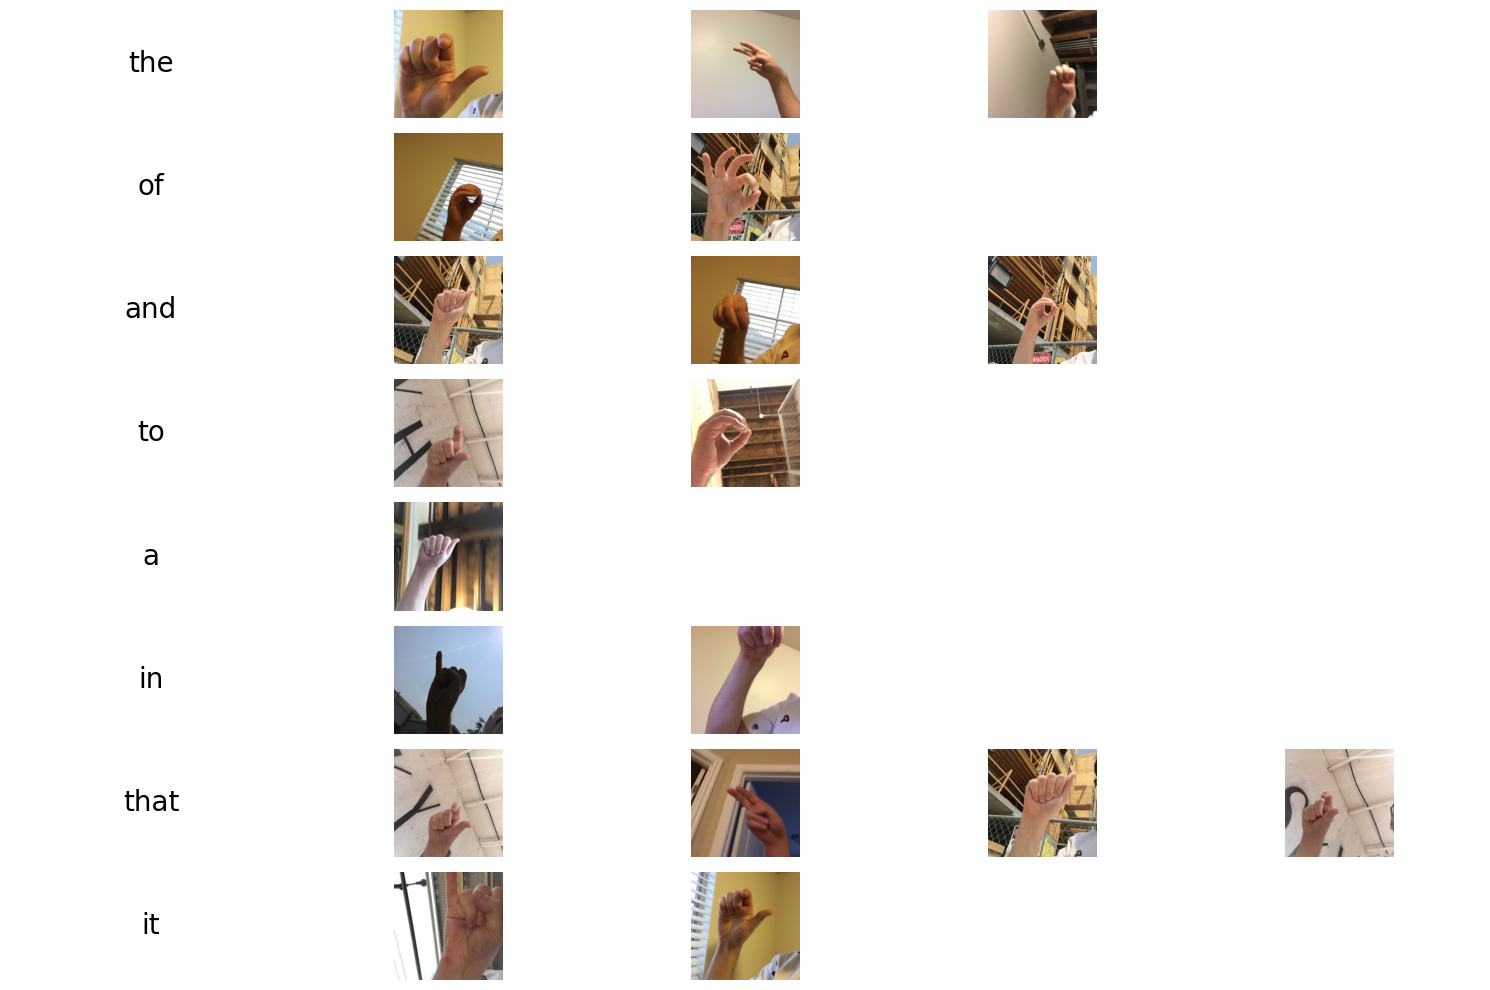

In [6]:
import os
import random
import matplotlib.pyplot as plt
from IPython.display import display, Image

# Set base paths and common words
path_to_test = os.path.join(input_dir, 'asl-alphabet-test', 'asl-alphabet-test')
words_demo = ["the", "of", "and", "to", "a", "in", "that", "it"]

# Function: Randomly select a picture from the folder with the specified letter
def random_image(letter):
    letter_path = os.path.join(path_to_test, letter)
    images = os.listdir(letter_path)
    random_image_filename = random.choice(images)
    return os.path.join(letter_path, random_image_filename)

# Generate a list of image paths for common words
selected_images = []
for word in words_demo:
    word_images = []
    for letter in word.upper():
        if letter.isalpha():  
            img_path = random_image(letter)
            word_images.append(img_path)
    selected_images.append(word_images)

# Calculate max number of columns
max_cols = max(len(images) for images in selected_images) + 1  # Add one for the label column
fig, axes = plt.subplots(len(words_demo), max_cols, figsize=(15, 10), squeeze=False)

for row, word_images in enumerate(selected_images):
    # Set the label in the first column with a larger font size
    axes[row, 0].text(0.5, 0.5, words_demo[row], va='center', ha='center', fontsize=20, transform=axes[row, 0].transAxes)
    axes[row, 0].axis('off')  # Hide the frame and ticks

    # Display images in the subsequent columns
    for col in range(1, max_cols):  # Start from 1 to leave space for the label
        if col-1 < len(word_images):  # Adjust index for images
            img_path = word_images[col-1]  # Adjust index to access image
            img = plt.imread(img_path)
            axes[row, col].imshow(img)
            axes[row, col].axis('off')
        else:
            axes[row, col].axis('off')  # Turn off unused axes

plt.tight_layout()
plt.savefig('test_img_generation.png')
plt.show()


### 2.2 Word recognition without text analysis techniques

In [29]:
# Load the model
import torch
import torchvision.transforms as transforms
import torchvision.models as models
from PIL import Image

if model_choice == 'ResNet18':
    saved_model = models.resnet18(pretrained=False)
    model_path = '../ResNet/ResNet18/outputs/fine_tuned_ResNet18.pth'
elif model_choice == 'ResNet34':
    saved_model = models.resnet34(pretrained=False)
    model_path = '../ResNet/ResNet34/outputs/fine_tuned_ResNet34.pth'
elif model_choice == 'ResNet152':
    saved_model = models.resnet152(pretrained=False)
    model_path = '../ResNet/ResNet152/outputs/fine_tuned_ResNet152.pth'
elif model_choice == 'InceptionV3':
    saved_model = models.inception_v3(pretrained=False)
    model_path = '../InceptionV3/outputs/fine_tuned_InceptionV3.pth'
elif model_choice == 'AlexNet':
    saved_model = models.alexnet(pretrained=False)
    model_path = '../AlexNet/outputs/fine_tuned_AlexNet.pth'

# Set the number of categories
num_classes = 29  # Make sure this matches the number of categories used when training

# Adjust the fully connected layer to match the number of categories
if 'ResNet' in model_choice or model_choice == 'InceptionV3':
    num_ftrs = saved_model.fc.in_features
    saved_model.fc = torch.nn.Linear(num_ftrs, num_classes)
elif model_choice == 'AlexNet':
    num_ftrs = saved_model.classifier[6].in_features
    saved_model.classifier[6] = torch.nn.Linear(num_ftrs, num_classes)

# Load the model state dictionary
model_state_dict = torch.load(model_path)
saved_model.load_state_dict(model_state_dict)

# Transfer the model to the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
saved_model = saved_model.to(device)

# Set to evaluation mode
saved_model.eval()


D:\softwares\Anaconda3\envs\CS766\lib\site-packages\torchvision\models\inception.py:43: FutureWarning: The default weight initialization of inception_v3 will be changed in future releases of torchvision. If you wish to keep the old behavior (which leads to long initialization times due to scipy/scipy#11299), please set init_weights=True.
  warnings.warn(


Inception3(
  (Conv2d_1a_3x3): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2a_3x3): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2b_3x3): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Conv2d_3b_1x1): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_4a_3x3): BasicConv2d(
    (conv): Conv2d(80, 192, kernel_size=(3, 3), stri

In [30]:
transform=transforms.Compose([
    transforms.Resize((299, 299)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Function: Recognize letters in pictures
def recognize_image(image_path):
    image = Image.open(image_path) 
    image = transform(image).unsqueeze(0).to(device)
    with torch.no_grad():
        outputs = saved_model(image)
        _, predicted = torch.max(outputs, 1)
        return predicted

# The sequence of pictures generated for each word is recognized and compared with the original word
correct_count = 0
total_count = 0
errors = []

for word in words:
    recognized_letters = ''
    for letter in word.upper():
        if letter.isalpha():
            image_path = random_image(letter)
            predicted_letter = recognize_image(image_path)
            recognized_letters += chr(predicted_letter + ord('A'))
    
    if recognized_letters == word.upper():
        correct_count += 1
    else:
        errors.append((word, recognized_letters.lower()))
    
    total_count += 1


accuracy = (correct_count / total_count) * 100
print(f'Accuracy: {accuracy:.2f}%')
print('Errors:', errors)

Accuracy: 13.00%
Errors: [('the', 'ahe'), ('to', 'zd'), ('and', 'aad'), ('of', 'cf'), ('a', 'f'), ('in', 'ym'), ('i', 'd'), ('is', 'db'), ('that', 'xhft'), ('you', 'yob'), ('on', 'om'), ('with', 'wixh'), ('was', 'wfz'), ('as', 'ae'), ('are', 'fbm'), ('have', 'hfkb'), ('at', 'fa'), ('he', 'h\\'), ('not', 'aoz'), ('but', 'bbx'), ('or', 'ok'), ('we', 'wb'), ('an', 'am'), ('your', 'ydbb'), ('all', 'fll'), ('so', 'zo'), ('his', 'hab'), ('they', 'th\\y'), ('me', 'hm'), ('one', 'dme'), ('can', 'cfm'), ('just', 'jfjz'), ('about', '\\\\dba'), ('out', 'obs'), ('what', 'khft'), ('has', 'hff'), ('when', 'whem'), ('more', 'mcra'), ('no', 'ma'), ('were', 'wmre'), ('who', 'kho'), ('had', 'hlc'), ("it's", 'ize'), ('their', 'shmir'), ('there', 'xher\\'), ('her', 'h\\b'), ('which', 'whifh'), ('time', 'xim\\'), ('get', 'gez'), ('been', '\\eea'), ('would', 'wcbdc'), ('she', 'zha'), ('new', 'bew'), ('people', 'p\\opl\\'), ('how', 'hdw'), ("don't", 'dcms'), ('also', 'flec'), ('them', 'xheh'), ('now', 'mow')

### 2.3 Word recognition with text analysis techniques


In [13]:
def levenshtein_distance(s1, s2):
    if len(s1) < len(s2):
        return levenshtein_distance(s2, s1)

    if len(s2) == 0:
        return len(s1)

    previous_row = range(len(s2) + 1)
    for i, c1 in enumerate(s1):
        current_row = [i + 1]
        for j, c2 in enumerate(s2):
            insertions = previous_row[j + 1] + 1
            deletions = current_row[j] + 1
            substitutions = previous_row[j] + (c1 != c2)
            current_row.append(min(insertions, deletions, substitutions))
        previous_row = current_row

    return previous_row[-1]


In [14]:
def find_closest_word(predicted_word, word_list):
    filtered_words = [word for word in word_list if len(word) == len(predicted_word)]
    closest_word = None
    min_distance = float('inf')
    for word in filtered_words:
        distance = levenshtein_distance(predicted_word, word)
        if distance < min_distance:
            min_distance = distance
            closest_word = word
    return closest_word



In [31]:
correct_count = 0
total_count = 0
errors = []

for word in words:
    recognized_letters = ''
    for letter in word.upper():
        if letter.isalpha():
            image_path = random_image(letter)
            predicted_letter = recognize_image(image_path)
            recognized_letters += chr(predicted_letter + ord('A'))
    
    closest_word = find_closest_word(recognized_letters.lower(), word_list)
    if closest_word == word.lower():
        correct_count += 1
    else:
        errors.append((word, closest_word))
    
    total_count += 1


accuracy = (correct_count / total_count) * 100
print(f'Accuracy: {accuracy:.2f}%')
print('Errors:', errors)


Accuracy: 60.00%
Errors: [('the', 'she'), ('a', 'f'), ('in', 'do'), ('is', 'in'), ('that', 'this'), ('it', 'in'), ('on', 'do'), ('was', 'off'), ('as', 'to'), ('at', 'it'), ('not', 'mom'), ('but', 'the'), ('an', 'am'), ('so', 'to'), ('me', 'to'), ('if', 'of'), ('one', 'due'), ('will', 'kind'), ('out', 'the'), ('has', 'his'), ('when', 'they'), ('no', 'my'), ("it's", 'was'), ('get', 'all'), ('she', 'the'), ("don't", 'damn'), ('also', 'feel'), ('now', 'law'), ("i'm", 'in'), ('its', 'for'), ('than', 'them'), ('good', 'from'), ('only', 'will'), ('into', 'also'), ('see', 'not'), ('then', 'area'), ('these', 'there'), ('us', 'is'), ('want', 'with'), ('go', 'to')]
